## Predicting Heart Disease

### Introduction:



According to the CDC, one person dies every 33 seconds from heart disease in the United States. Heart disease is a condition that affects the heart and blood vessels.Though there is no definite cure, it is possible to alleviate symptoms and prevent the condition from worsening and becoming fatal via lifestyle changes and medications. The question we will be answering is: Can we predict the severity of heart disease in a patient based on health measurements taken in the hospital? We will be using the “Heart Disease'' dataset from the UC Irvine Machine Learning Repository which provides health and lifestyle characteristics of patients, and whether the patient is diagnosed with heart disease as well as its severity, ranging from 0 (no presence) to 4. 

**Predictive Question**: Can we predict the severity of heart disease in a patient based on health measurments taken in the hospital?

**Dataset**: Heart Disease Dataset. It has 14 variables:

- Age: Years
- Sex : 1 = male , 0 = female
- cp :  chest pain type
- trestbps : resting blood pressure (mm Hg)
- chol :  serum cholesterol (mg/dl)
- fbs :   fasting blood sugar   ( 1: fbs >120mg/dl, 0 : fbx <120 mg/dl)
- Restecg : resting electrocardiographic results
- Thalach : maximum heart rate achieved
- exang :  exercise induced angina 
- Oldpeak : ST depression induced by exercise relative to rest
- Slope : slope of the peak exercise ST segment ( 1: upsloping, 2: flat,  downsloping)
- ca :   number of major vessels (0-3) colored by fluoroscopy
- Thal : normal, fixed defect, reversible defect
- Num :  Level of heart disease 

Other characteristics:
There is some missing data in the dataset. 


### Preliminary Exploratory Data Analysis:

In [39]:
### Loading the relevant libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library("RColorBrewer")

set.seed(1234)

#### Reading the Data 

In [12]:
#Reading the data from Github

#URl of the raw clevland.data file 
url <- "https://raw.githubusercontent.com/sachit-sharma/dsci-100-group-project-group53/main/processed.cleveland.data"
column_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldspeak", "slope", "ca", "thal", "num")

heart_disease_data <- read_csv(url, col_names = column_names) |>
                       mutate (sex = as.factor(sex), 
                              thal = as.factor(thal), 
                              num = as.factor(num), 
                              cp = as.factor(cp), 
                              fbs = as.factor(fbs), 
                              restecg = as.factor(restecg), 
                              exang = as.factor(exang), 
                              ca = as.factor(ca),
                              slope = as.numeric(slope), 
                               trestbps = as.numeric(trestbps), 
                               chol = as.numeric(trestbps),
                               oldspeak = as.numeric(oldspeak), 
                               thalach = as.numeric(thalach))|>
                               rename(class = num)
#Changing all ? to NA
heart_disease_data[ heart_disease_data == "?"] <- NA 

#Removing all nas for the predictors
heart_disease_data <- heart_disease_data |>
                      filter(!is.na(age), !is.na(thalach), !is.na(chol), !is.na(trestbps), !is.na(oldspeak), !is.na(slope))

head(heart_disease_data)

Rows: 626 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): trestbps, chol, fbs, restecg, thalach, exang, oldspeak, slope, ca,...
dbl  (4): age, sex, cp, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldspeak,slope,ca,thal,class
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
63,1,1,145,145,1.0,2.0,150,0.0,2.3,3,0.0,6.0,0
67,1,4,160,160,0.0,2.0,108,1.0,1.5,2,3.0,3.0,2
67,1,4,120,120,0.0,2.0,129,1.0,2.6,2,2.0,7.0,1
37,1,3,130,130,0.0,0.0,187,0.0,3.5,3,0.0,3.0,0
41,0,2,130,130,0.0,2.0,172,0.0,1.4,1,0.0,3.0,0
56,1,2,120,120,0.0,0.0,178,0.0,0.8,1,0.0,3.0,0


We now split the data into testin and  trainig. We use 75% of our data for training and 25% for testing. We will keep the testing data aside for testing the accuracy of the model, and use the training data to train and tune the model.

In [13]:
#Splitting the data into training and testing
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = class)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

#### Calculating the mean of our predictors

In [14]:
#Calculating the mean value of the predictors 

heart_disease_select <-  heart_disease_train |>
                         select(age, trestbps, chol, thalach)

mean_values <- heart_disease_select |>
               map_df(mean, na.rm = TRUE)
mean_values

age,trestbps,chol,thalach
<dbl>,<dbl>,<dbl>,<dbl>
55.66844,131.7003,131.7003,138.8011


The mean value of the predictors we are using are:

- Age : 56.3
- Tresbps (Resting Blood Pressure) : 131 mm of Hg
- Serum Cholestrol :131.62 mg/dl
- Thalach (Maximum Heart Rate) : 136.7 bpm

#### Calculating the Maximum and Minimum values of our predictors

In [20]:
#Calculating the max of the predictors 

max_obs <-  heart_disease_select |>
            map_df(max, na.rm = TRUE)
max_obs 

age,trestbps,chol,thalach
<dbl>,<dbl>,<dbl>,<dbl>
77,200,200,195


In [22]:
#Calculating the min of the predictors 
min_obs <- heart_disease_select |>
           map_df(min, na.rm = TRUE)
min_obs

age,trestbps,chol,thalach
<dbl>,<dbl>,<dbl>,<dbl>
32,94,94,60


#### Calculating Distribution of the Classes

In [7]:

#Calculating the distribution of classes 

class_pct <- heart_disease_train |> 
             group_by(class) |>
             summarize(percentage = n()*100/nrow(heart_disease_train))
class_pct 

class,percentage
<fct>,<dbl>
0,37.037037
1,24.338624
2,17.460317
3,15.873016
4,5.291005



It is clear that the class 0 (absence of disease)is in the majority in the data set. The next most observed class is the presence of the lowest level of heart disease. Heart disease of level  4 is the least common in our data set. If a majority classifier was used, then it would only have a 35.04% accuracy. Looking at the the imbalance in the data, upsampling would be an important step. Later, in the discussion, we explain why upsampling was not performed.

#### Preliminary Graphic Analysis ####

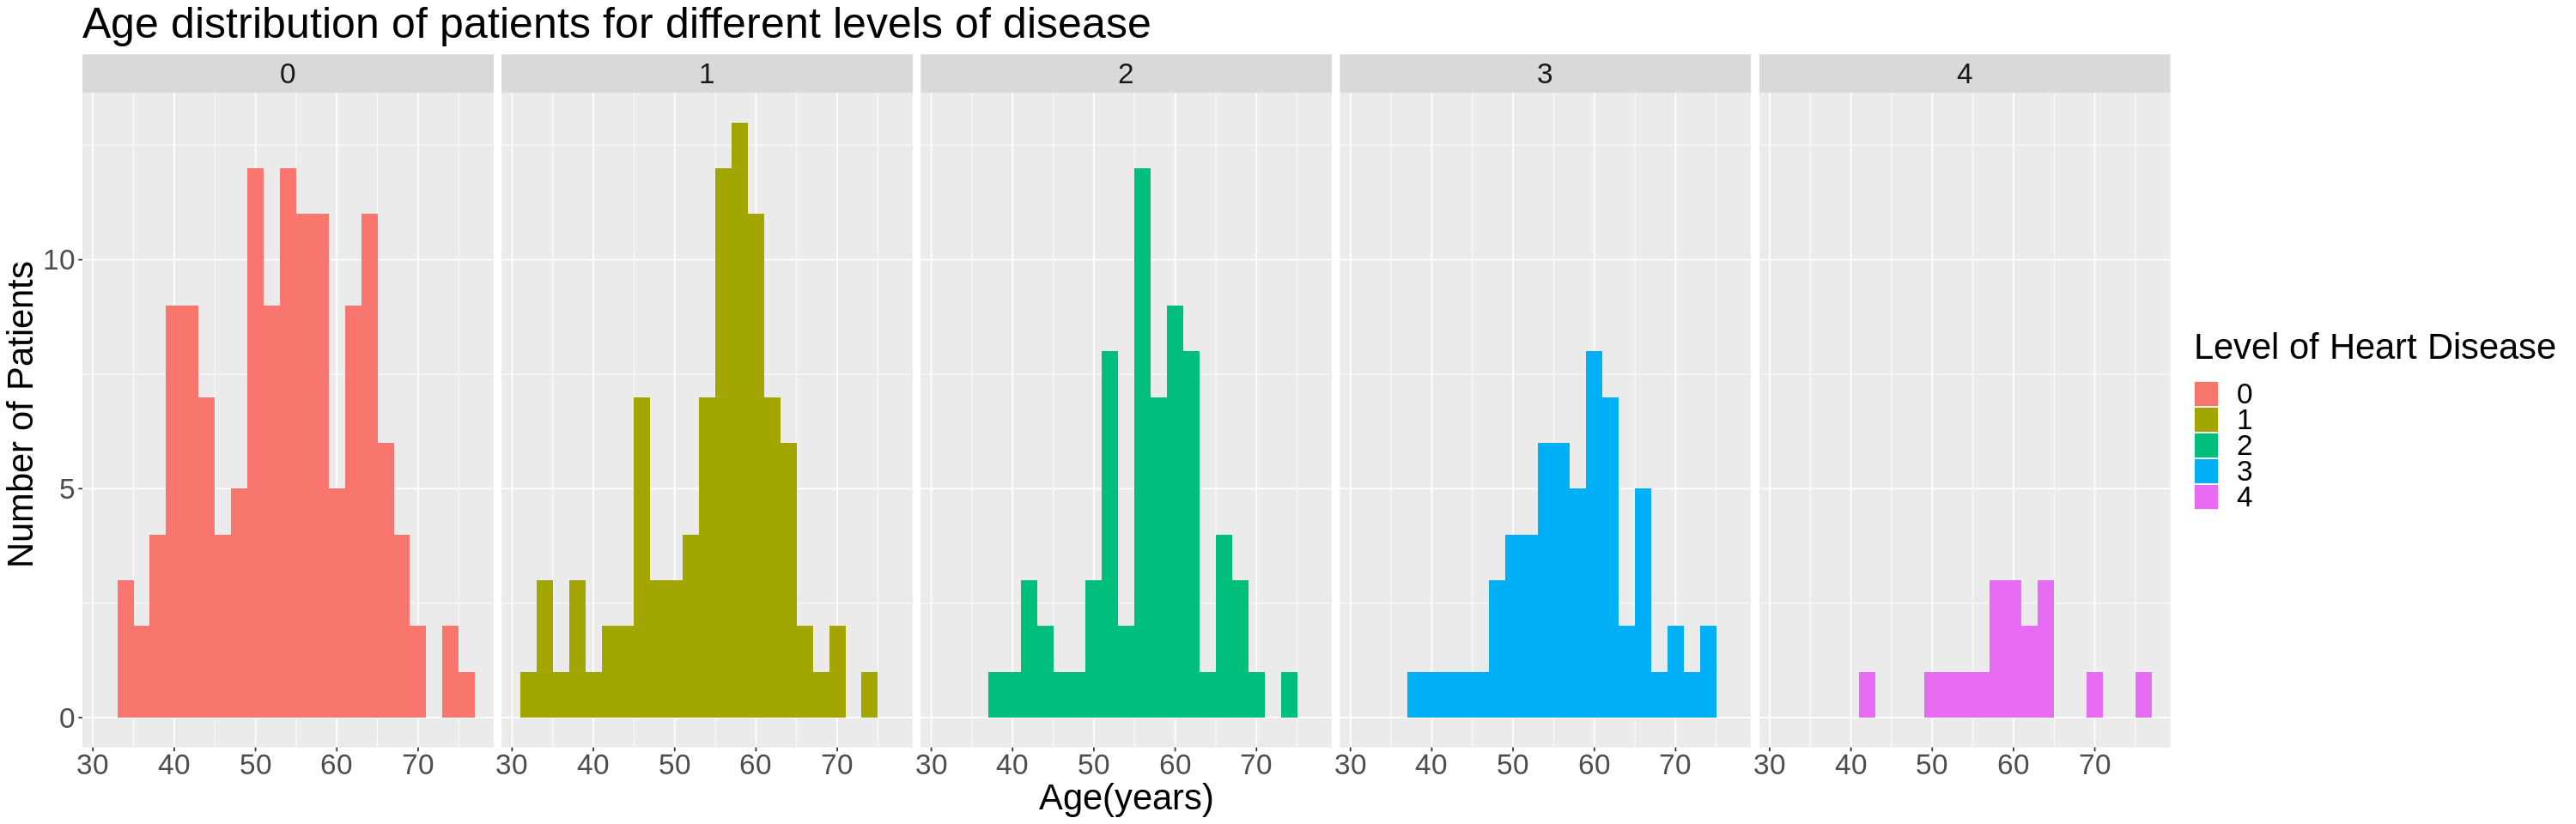

In [80]:
options(repr.plot.width = 25, repr.plot.height = 8)

age_hist <- ggplot(heart_disease_train,  aes(x = age, fill = class))  +
             geom_histogram(binwidth = 2) +
             labs(x = "Age(years)",  y = " Number of Patients", fill = "Level of Heart Disease") +
             facet_grid(cols = vars(class)) +
             scale_color_brewer(palette = "Set2") +
             ggtitle("Age distribution of patients for different levels of disease" ) +
             theme(text = element_text(size = 25)) 
age_hist

The mean age of the people with no disease is around 50-55. But for higher levels of heart disease, the mean age is greater than 60. We can also see that for level 4 disease (the highest level of heart disease), there are no patients below the age of 40.  This suggests that age might be a good predictor for level of heart diesease. 

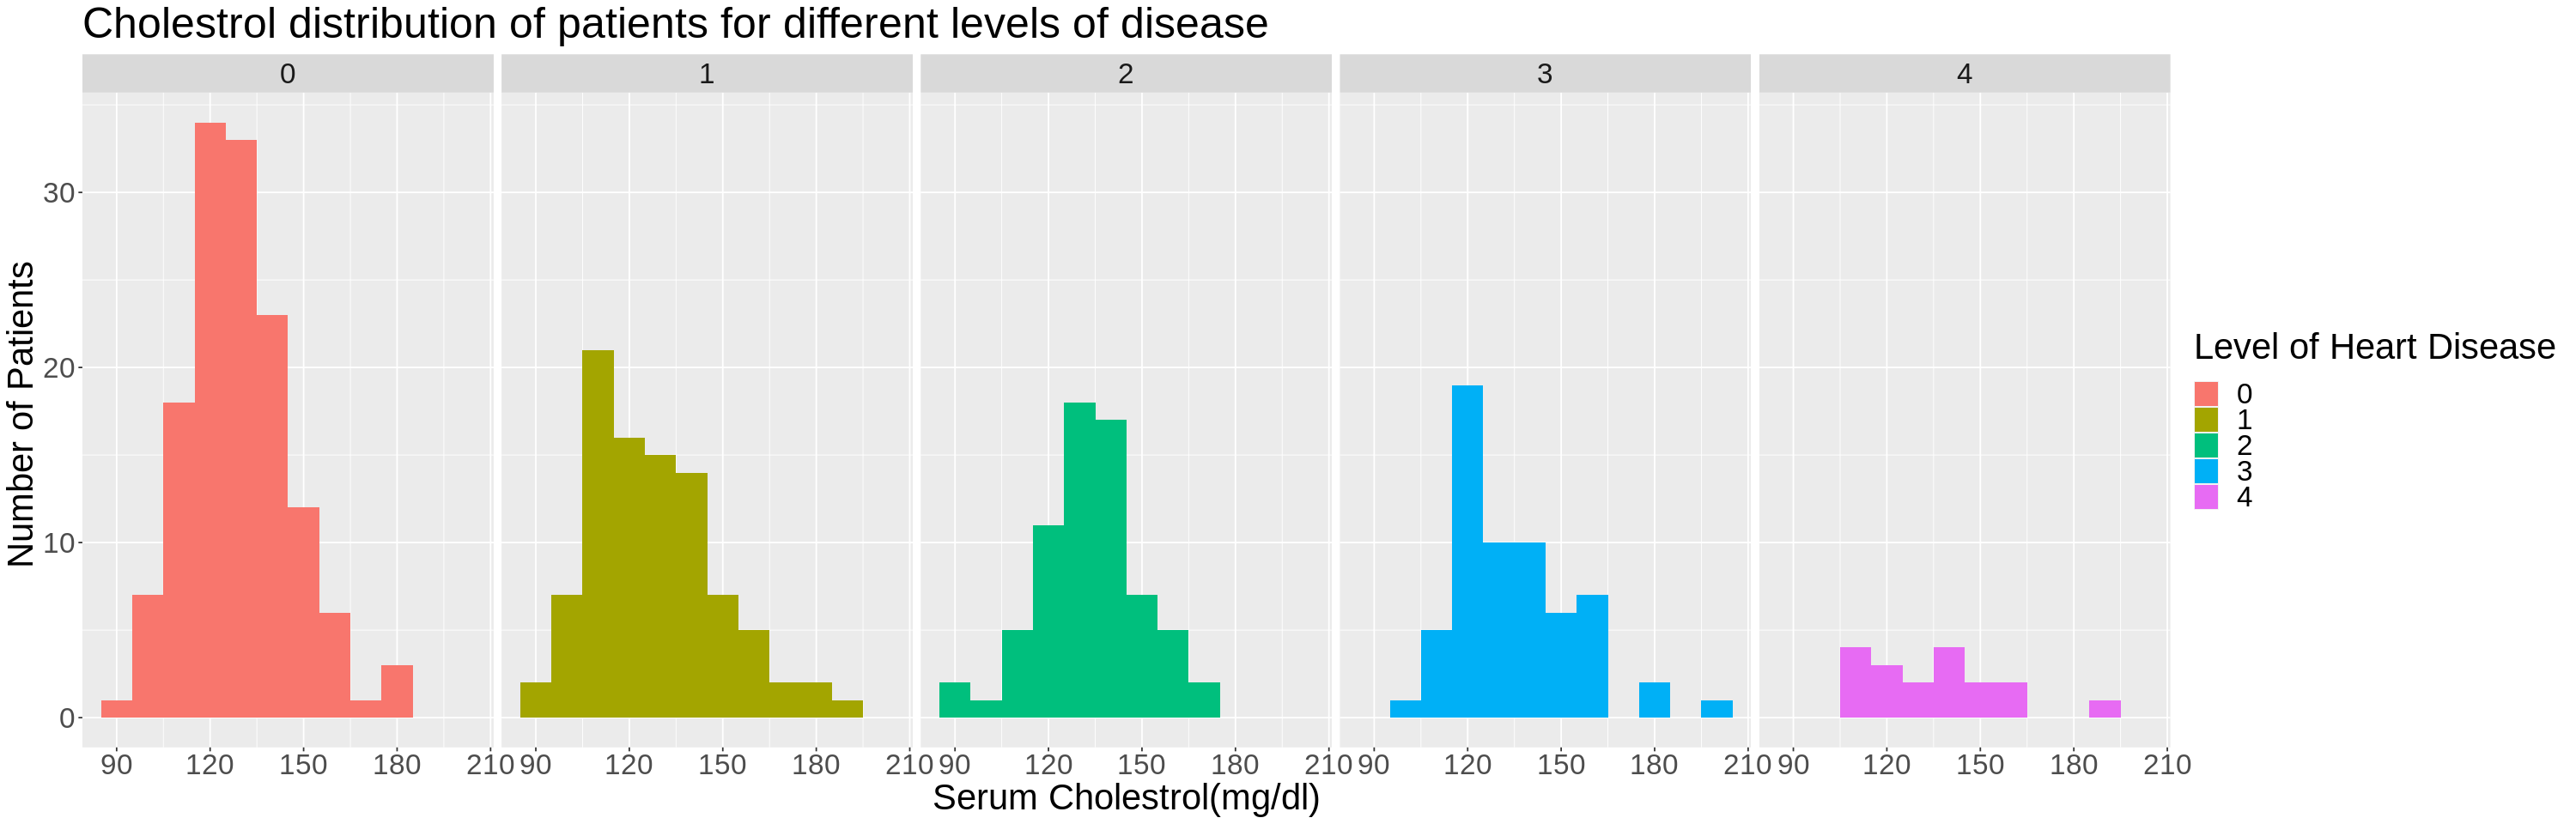

In [94]:
options(repr.plot.width = 25, repr.plot.height = 8)
chol_hist <- ggplot(heart_disease_train, aes(x = chol, fill = class)) + 
             geom_histogram(binwidth = 10) +
             labs(x = "Serum Cholestrol(mg/dl)", 
                  y = " Number of Patients", 
                  fill = "Level of Heart Disease") +
             ggtitle("Cholestrol distribution of patients for different levels of disease" ) +
             facet_grid(cols = vars(class)) +
             theme(text = element_text(size = 25))
chol_hist

The centre of the cholestrol distribution for patients with no heart disease is approximately 120. 

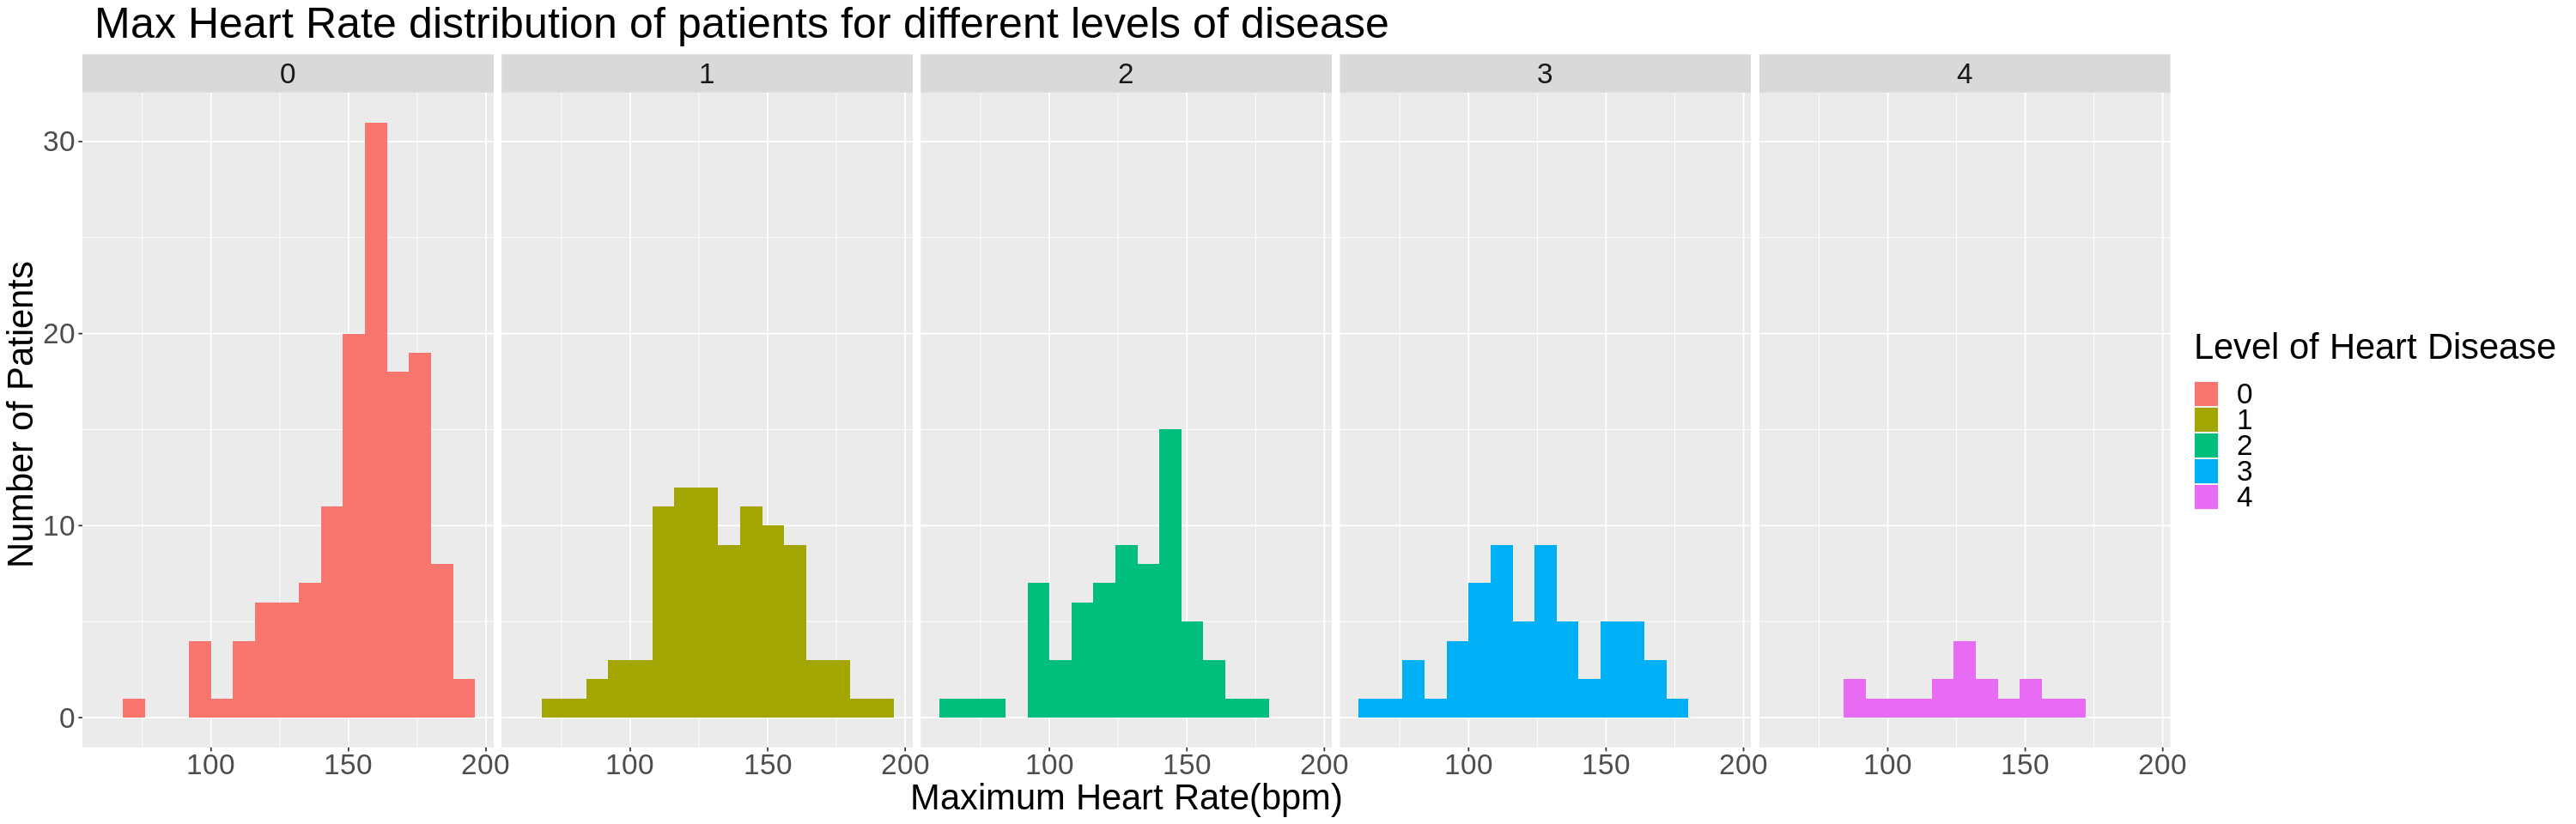

In [95]:
options(repr.plot.width = 25, repr.plot.height = 8)
thalach_hist <- ggplot(heart_disease_train,  aes(x = thalach, fill = class))  +
               geom_histogram(binwidth = 8) +
               labs(x = "Maximum Heart Rate(bpm)",  y = " Number of Patients", fill = "Level of Heart Disease") +
               facet_grid(cols = vars(class)) +
               scale_color_brewer(palette = "Set2") +
               ggtitle(" Max Heart Rate distribution of patients for different levels of disease" ) +
             theme(text = element_text(size = 25)) 
thalach_hist

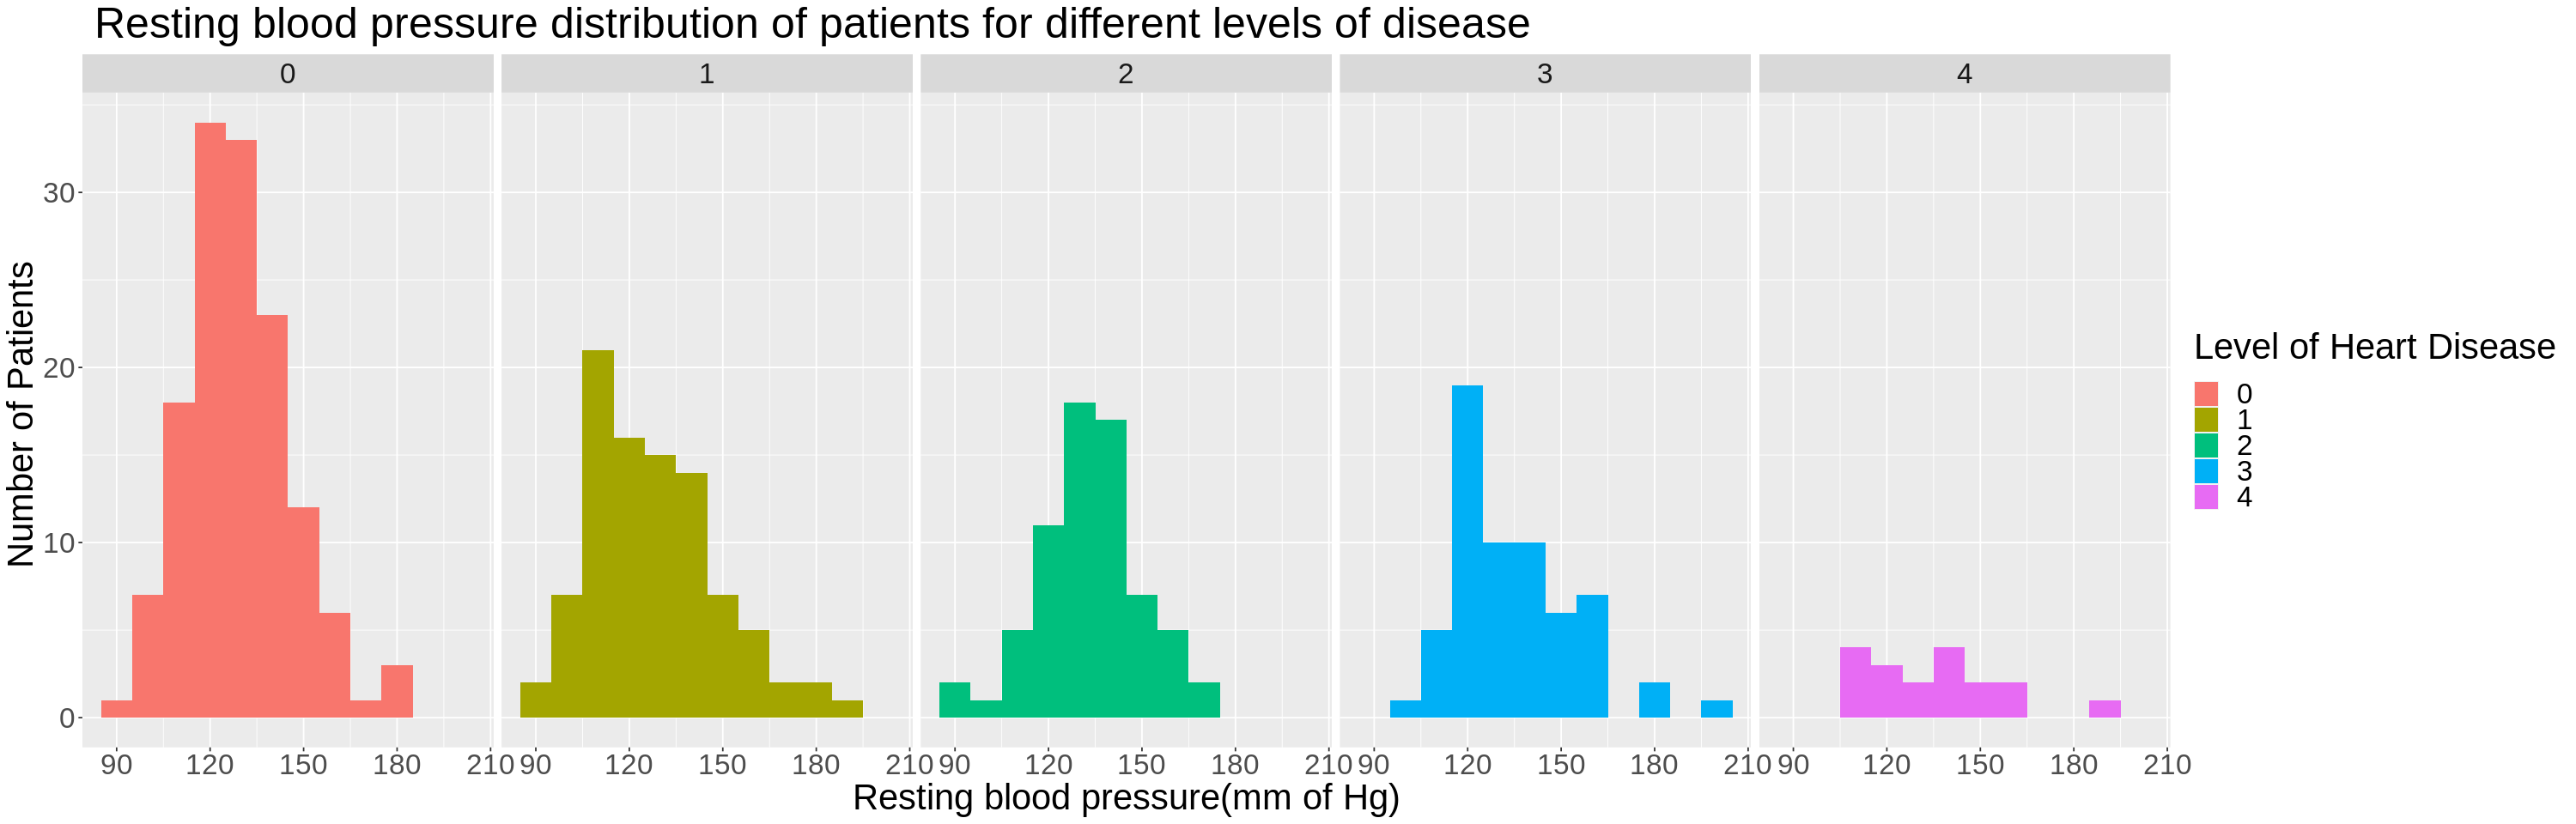

In [88]:
options(repr.plot.width = 25, repr.plot.height = 8)
bp_hist <- ggplot(heart_disease_train,  aes(x = trestbps, fill = class))  +
               geom_histogram(binwidth = 10) +
               labs(x = "Resting blood pressure(mm of Hg)",  y = " Number of Patients", fill = "Level of Heart Disease") +
               facet_grid(cols = vars(class)) +
               scale_color_brewer(palette = "Set2") +
               ggtitle(" Resting blood pressure distribution of patients for different levels of disease" ) +
             theme(text = element_text(size = 25)) 
bp_hist

The above plots show the distribution of the predictor variables in the data set. 

### Methods:

Having many predictors is good, but it is important to ensure they are relevant. Irrelevant predictors add noise and decrease accuracy.

#### Reasons for chosing the predictors 
The predictors we will use are age, serum cholesterol (chol), maximum heart rate achieved (thalach), and resting blood pressure (trestpbps). We chose these because of a combination of scientific research and our own intuition of what contributes to heart disease. 

- **Age**: According to the American Heart Association (AHA), the incidence of heart disease in US mean and women is ~40% from 40-59 years, ~75% from 60-79 years and ~86% in those above the age of 80. This suggests that old age can be a significant factor towards predicting heart disease (Rodgers et al.,2019)

- **Cholestrol (chol)**: According to the study conducted by Jung et al.(2022), high serum cholesterol, which is composed of both high-density lipoprotein(HDL) and low-density lipoprotein(LDL), is shown to be associated with an increased mortality due to heart disease. As a result high cholestrol levels, can be a good predictor for high levels of heart disease. 

- **Maximum Heart Rate (thalach)** : A study by Peter-Guillaume et al.(2009)  found that high heart rate was a signifcant factor for cardiovasuclar disease. The study found that high heart rate was also associated with other risk factors for heart disease such as high blood pressure. As a result, we can expect high heart rate to be a predictor of high levels of heart disease. 

- **Resting Blood Pressure (trestpbs)** : Wu et al.(2015) found that stage 2-3 hypertension( blood presure >140 mm Hg) was associated with increased risk of cardiovascular disease and mortality among older adults. Thus, it can also serve as a good predictor. 

All four variables are significant so they will be predictors. 

There are many ways to make predictions for classification problems but we will use the K-nearest-neighbors algorithm. Through the steps of visualizing, evaluating, and tuning our data, we will attempt to accurately predict the severity of heart disease. 

We will use a scatter plot of the standardized predictors in order to visualize trends in severity of heart disease compared to our variables. 

We are using the K-neighbors algorithm so we will be making a combined scatter and line plot comparing  “neighbors” to “estimated accuracy”. This allows us to find the optimal k value which yields the best accuracy. 


References

1. Rodgers, J. L., Jones, J., Bolleddu, S. I., Vanthenapalli, S., Rodgers, L. E., Shah, K., ... & Panguluri, S. K. (2019). Cardiovascular risks associated with gender and aging. *Journal of cardiovascular development and disease, 6*(2), 19. https://doi.org/10.3390/jcdd6020019



### Expected Outcomes and Significance:

We expect to predict the severity of heart disease based on an individual’s physical health. We predict age, cholesterol levels, and resting blood pressure will be positively correlated to heart disease. Conversely, the maximum achievable heart rate will be negatively correlated with heart disease. These findings can help determine who may be at a higher risk of developing heart disease and prevent it. 

### Forward Selection

In addition to the literature discussed, we perform forward selection to determine which predictors to use in our model. 

In [99]:
library(dplyr)
library(tidymodels)

# # Reference: https://datasciencebook.ca/classification2.html#forward-selection-in-r
# #Creating the column names 

heart_disease_select <- heart_disease_train |>
                        select(age, chol, thalach, slope, oldspeak, trestbps, class)

names <- colnames(heart_disease_select |> select(-class))

# # create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# # create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# # create a 5-fold cross-validation object
heart_disease_vfold <- vfold_cv(heart_disease_select, v = 5, strata = class)

# # store the total number of predictors
n_total <- length(names)

# # stores selected predictors
selected <- c()

# # for every size from 1 to the total number of predictors
for (i in 1:n_total) {
# #     # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("class", "~", paste(preds_new, collapse="+"))

# #         # create a recipe from the model string
    heart_disease_recipe <- recipe(as.formula(model_string), 
                                   data = heart_disease_select) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

# #         # tune the KNN classifier with these predictors, 
# #         # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(heart_disease_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_disease_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

# #         # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies




size,model_string,accuracy
<int>,<chr>,<dbl>
1,class ~ thalach,0.4033735
2,class ~ thalach+oldspeak,0.4477893
3,class ~ thalach+oldspeak+age,0.4556341
4,class ~ thalach+oldspeak+age+chol,0.4454608
5,class ~ thalach+oldspeak+age+chol+trestbps,0.4399529
6,class ~ thalach+oldspeak+age+chol+trestbps+slope,0.4237838


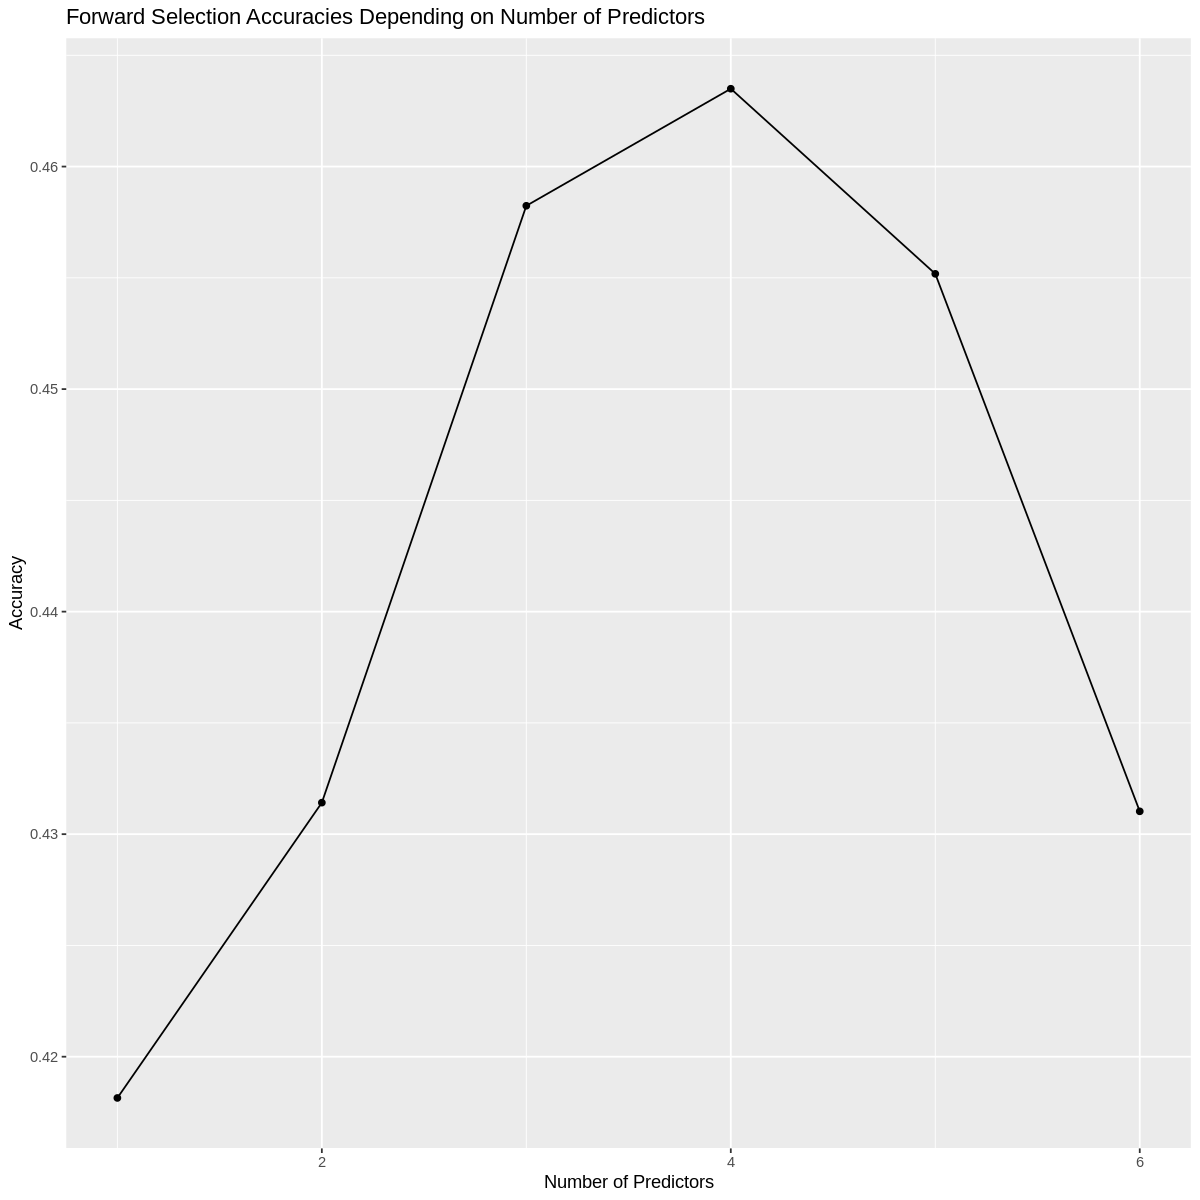

In [11]:
fs_plot <- accuracies |> 
ggplot(aes(x = size, y = accuracy)) + 
geom_point() + 
geom_line() + 
labs(x = "Number of Predictors", y = "Accuracy") +
ggtitle ("Forward Selection Accuracies Depending on Number of Predictors")

fs_plot

Forward selection suggests that the predictors that maximise accuracy are oldspeak, slope, chol, thalach. We drop the predictors age and tresbps and replace them with oldspeak and slope. Later in the discussion we explain how these predictors can influence heart disease. 

### Analysis of the Data

#### Performing cross validation and tuning to Determine the model parameters

In [107]:

#Creating 5 folds for cross validations
heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = class)

#Creating the recipe and performing centering, scaling and upsampling. 

heart_disease_recipe <- recipe(class ~ thalach + chol + oldspeak + slope, data = heart_disease_train) |>
                        step_center(all_predictors()) |>
                        step_scale(all_predictors())

#Creating the model specification for our knn classification model

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")
        
#Creating a data frame for k values 
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 2))
heart_disease_recipe 
knn_spec

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Centering for all_predictors()
Scaling for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [108]:
# Calculating the cross validation accuracy for all k values 
knn_results <- workflow() |>
               add_recipe(heart_disease_recipe) |>
               add_model(knn_spec) |>
               tune_grid(resamples = heart_disease_vfold, grid = k_vals)|>
               collect_metrics() |>
               filter(.metric == "accuracy")
knn_results            

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3799793,5,0.02740108,Preprocessor1_Model01
3,accuracy,multiclass,0.4300956,5,0.01671648,Preprocessor1_Model02
5,accuracy,multiclass,0.4140928,5,0.02241974,Preprocessor1_Model03
7,accuracy,multiclass,0.4088998,5,0.01908542,Preprocessor1_Model04
9,accuracy,multiclass,0.4009340,5,0.01546248,Preprocessor1_Model05
11,accuracy,multiclass,0.4038436,5,0.02658257,Preprocessor1_Model06
13,accuracy,multiclass,0.4169340,5,0.02364023,Preprocessor1_Model07
15,accuracy,multiclass,0.4088952,5,0.02065531,Preprocessor1_Model08
17,accuracy,multiclass,0.4062997,5,0.02663582,Preprocessor1_Model09


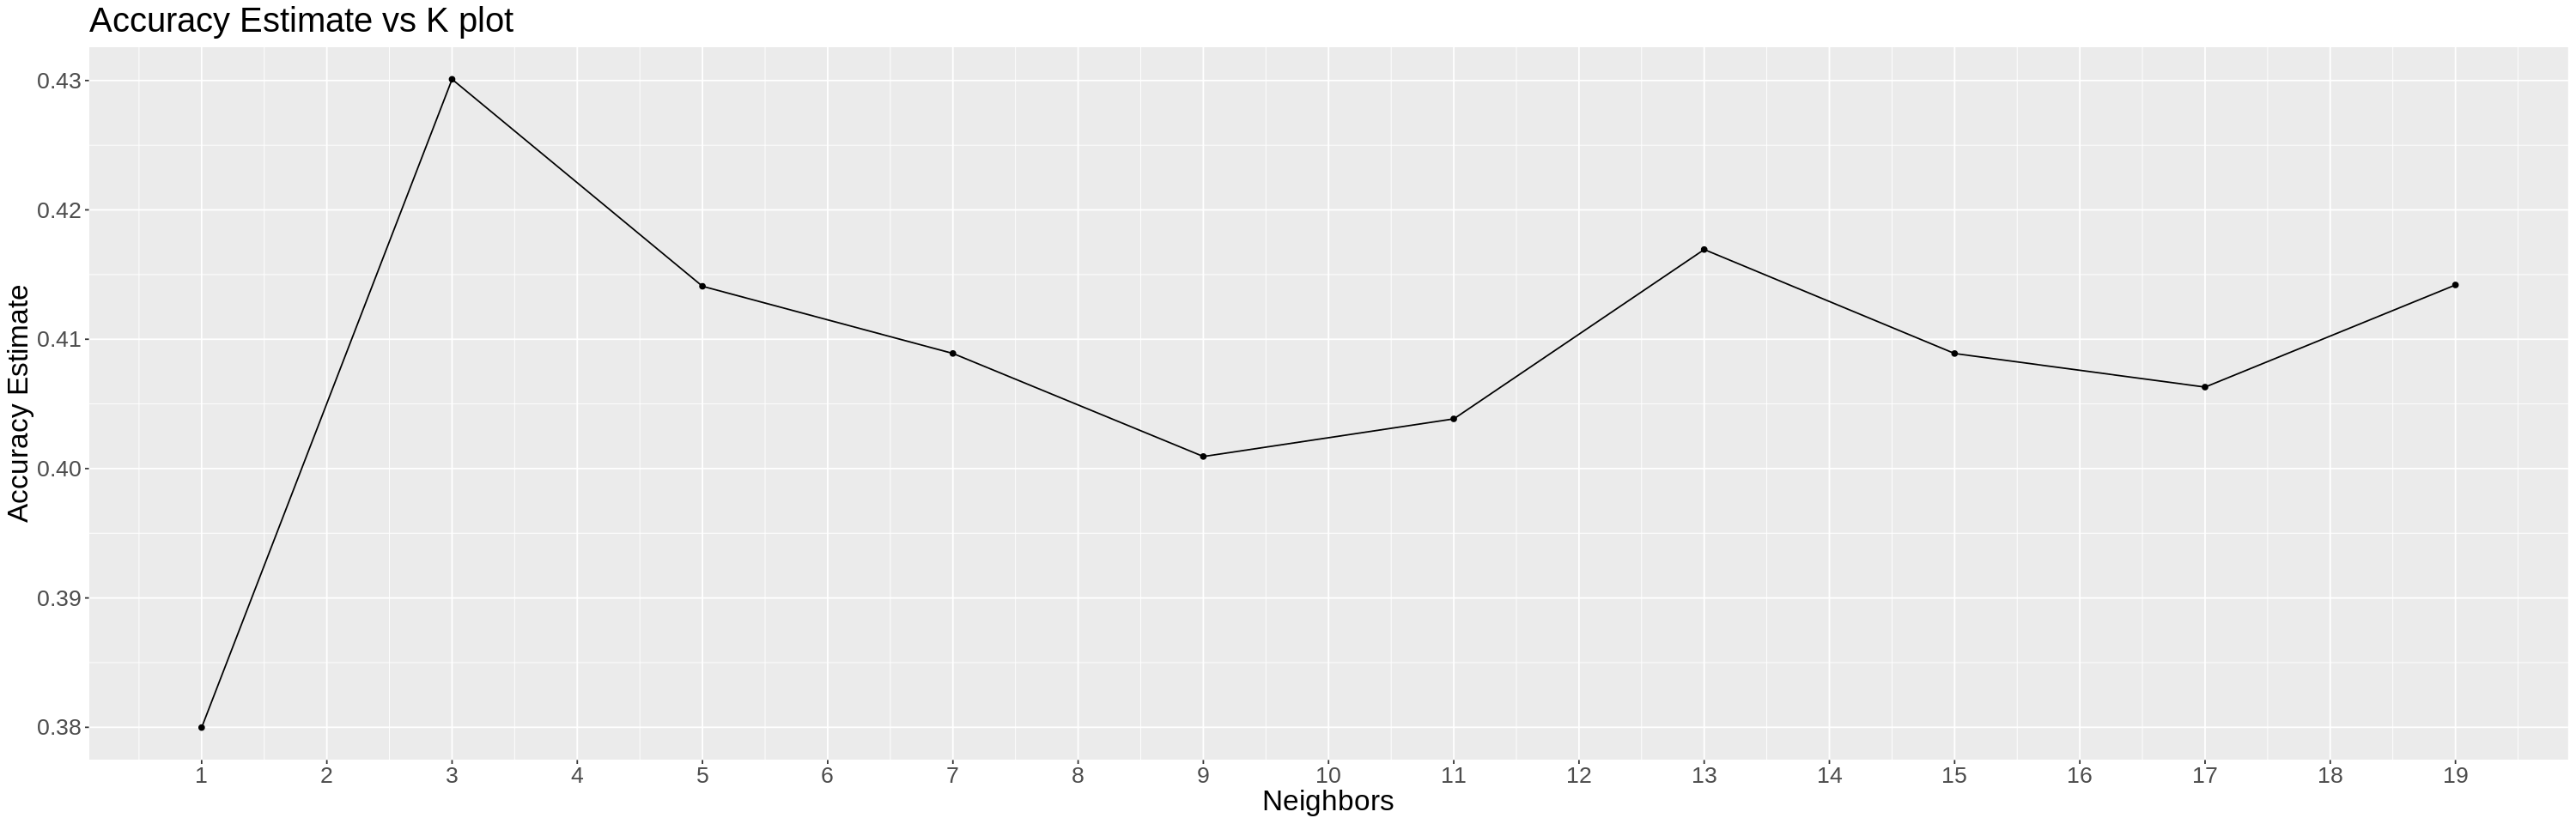

In [120]:
#Visualising the results using an accuracy estimate vs k plot 
accuracy_vs_k <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
  geom_point() + 
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  ggtitle("Accuracy Estimate vs K plot") +
  scale_x_continuous(breaks = 1:20) +
  theme(text = element_text(size = 20))
accuracy_vs_k 

The accuracy vs k plot suggests that the best k to use in the model is 3. This is where the accuracy peaks. We now create the final model with the parameter found here.

#### Creating the final model

In [121]:
#Retraining the model with best k 

knn_spec_best <- nearest_neighbor(weight_func = 'rectangular', neighbors = best_k) |>
                 set_engine("kknn") |>
                 set_mode("classification")

#Creating the workflow and fitting the model to the training dataset
knn_fit <- workflow() |>
           add_recipe(heart_disease_recipe) |>
           add_model(knn_spec_best) |>
           fit(data = heart_disease_train)  

#making the predictions and 
heart_disease_predictions <- knn_fit |>
                             predict(heart_disease_test) |>
                             bind_cols(heart_disease_test)

#computing the accuracy of the classifier

accuracy <- heart_disease_predictions |>
            metrics(truth = class, estimate = .pred_class)|>
            filter(.metric == "accuracy") 
accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.3828125


Confusion Matrix: 

In [ ]:
conf_mat( heart_disease_predictions, truth = class, estimate = .pred_class)

num_classes <- heart_disease_predictions |>
               group_by(class) |>
               summarize(count = n())
num_classes

          Truth
Prediction  0  1  2  3  4
         0 29 14  9  7  2
         1 10 13  4  4  0
         2  3  3  4  4  3
         3  6  3  3  3  1
         4  1  0  1  1  0

count
<int>
49
33
21
19
6


In [132]:
true_predictions <- heart_disease_predictions |> filter(class == .pred_class)

accuracy_predictions_by_class <- heart_disease_predictions |>
                                 select(.pred_class, class) |>
                                 filter(class == .pred_class) |>
                                 group_by(class) |>
                                 summarize(count = n()) 

total_count <- num_classes |> 
pull(count) |>
sum()

total_count 

percentage_correct <- mutate (accuracy_predictions_by_class , percentage = count / total_count * 100)

percentage_correct


[1] 128

class,count,percentage
<fct>,<int>,<dbl>
0,29,22.65625
1,13,10.15625
2,4,3.12500
3,3,2.34375


### Visualisation of Results

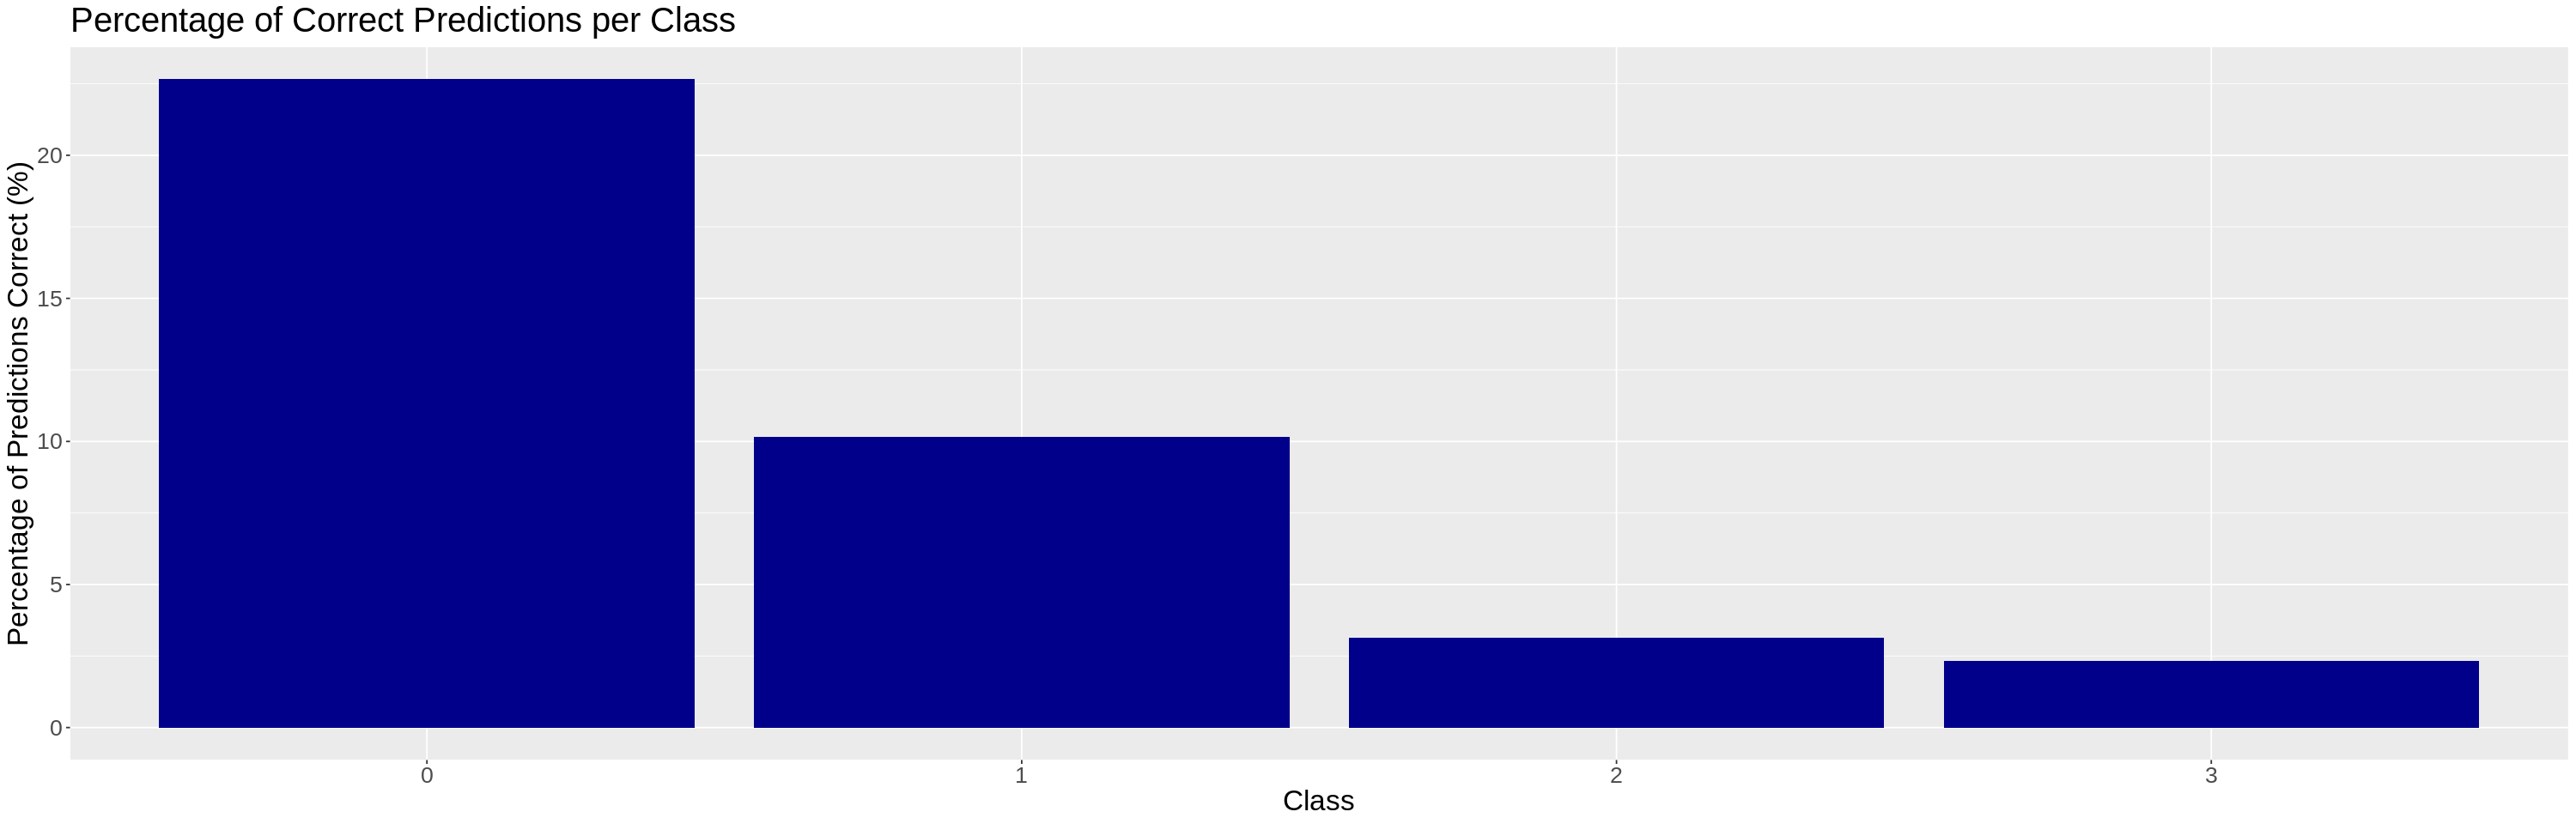

In [131]:
ggplot(percentage_correct, aes (x = class, y = percentage)) + 
geom_bar (stat = "identity", fill = "darkblue") +
labs (x = "Class", y = "Percentage of Predictions Correct (%)") + 
ggtitle ("Percentage of Correct Predictions per Class") + 
theme(text = element_text(size = 20))